# Human Activity Recognition for Healthy Lifestyle Monitoring (Team 44)

## Overview


In [ ]:
# Import required libraries
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.stats import skew, kurtosis

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder



## 0) Data Collection

## 1) Data Loading

### Raw Data Management

The raw dataset is organized into activity folders. Each folder corresponds to **one trial of one activity performed by one student**.  

Naming of Data  
- Format: **`{Activity}_{trial}_{student}`**  
- Example: `Sit_1_Student1`  

The dataset includes **five fundamental activities**, each represented by a short folder name:

- **Sitting Down** → `Sit`  

- **Standing Up** → `Stand`  

- **Walking** → `Walking`  

- **Running** → `Running`  

- **Climbing Stairs** → `Stairs`  

For our analysis, we will use only the calibrated sensor files for the following sensors of interest:
- `Accelerometer.csv` → linear acceleration (x, y, z)  
- `Gravity.csv` → device orientation relative to gravity (x, y, z)  
- `Gyroscope.csv` → angular velocity (x, y, z)  

In [24]:
# ----------------------------------------------------------
# Function to load raw data
# ----------------------------------------------------------
def load_raw_data(root_dir, sensors=("Accelerometer", "Gravity", "Gyroscope")):
    """
    Load raw sensor data into a nested dictionary.

    Structure:
        data[activity][trial][student][sensor] = DataFrame

    Folder naming convention:
        "{Activity}_{trial}_{student}"
        e.g. "Sit_1_Student1"
    """

    data = {}

    # Iterate over all folders in root_dir
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        # Match folder name pattern
        match = re.match(r"([A-Za-z]+)_(\d+)_([A-Za-z0-9]+)", folder)

        activity, trial, student = match.groups()

        # Initialize nested dictionary structure
        data.setdefault(activity, {}).setdefault(trial, {}).setdefault(student, {})

        # Load each sensor file if available
        for sensor in sensors:
            file_path = os.path.join(folder_path, f"{sensor}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                data[activity][trial][student][sensor.lower()] = df
            else:
                print(f"[load_raw_data] Missing {file_path}")

    return data

In [25]:
# Load the raw data 
data = load_raw_data("Raw Data")

### Loading the data

The `load_raw_data` function organizes the dataset into a **nested dictionary** with the following structure:

**`data[activity][trial][student][sensor] = DataFrame`**

#### Hierarchy Breakdown
- **activity** → type of movement (`"Sit"`, `"Stand"`, `"Walking"`, `"Stairs"`, `"Running"`)  
- **trial** → trial number for that activity (e.g., `"1"`, `"2"`)  
- **student** → participant identifier (`"Student1"`, `"Student2"`)  
- **sensor** → one of the chosen sensors (`"accelerometer"`, `"gyroscope"`, `"gravity"`)  

Each sensor entry is stored as a Pandas DataFrame containing the raw time-series data.

For example, the accelerometer data for Student1 performing Sit activity, trial 1 can be accessed by:

In [26]:
data["Sit"]["1"]["Student1"]["accelerometer"]

,time,seconds_elapsed,z,y,x
0,1759157635439398700,0.046399,-0.018303,0.185763,-0.340953
1,1759157635449457000,0.056457,-0.024306,0.200625,-0.232246
2,1759157635459516000,0.066516,-0.006346,0.178468,-0.168432
3,1759157635469573600,0.076574,-0.053671,0.133353,-0.122252
4,1759157635479632000,0.086632,-0.104921,0.097954,-0.082920
...,...,...,...,...,...
525,1759157640719951400,5.326951,0.121495,0.310511,0.033830
526,1759157640730009600,5.337010,-0.081366,0.240393,0.168840
527,1759157640740067600,5.347068,-0.059322,0.012517,0.094556
528,1759157640750125300,5.357125,0.230433,-0.295023,0.065098


This data can be visualised by plotting a graph.

In [ ]:
# ----------------------------------------------------------
# Function to plot raw sensor signals (x, y, z) over time
# ----------------------------------------------------------
def plot_sensors(sensor_data, activity_name="Activity"):
    """
    Plots x, y, z vs seconds_elapsed for Accelerometer, Gravity, and Gyroscope in separate subplots
    """

    # Create 3 subplots (one per sensor), share x-axis (time)
    fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
    fig.suptitle(f"{activity_name} Sensor Data", fontsize=16)

    # Loop through each sensor and plot x, y, z signals
    for ax, (sensor_name, df) in zip(axes, sensor_data.items()):
        ax.plot(df['seconds_elapsed'], df['x'], label='x')
        ax.plot(df['seconds_elapsed'], df['y'], label='y')
        ax.plot(df['seconds_elapsed'], df['z'], label='z')

        # Label subplot with sensor name (e.g., Accelerometer, Gravity, Gyroscope)
        ax.set_ylabel(sensor_name.capitalize())
        ax.legend()
        
    # Label x-axis (shared for all subplots)
    axes[-1].set_xlabel("Seconds Elapsed")
    plt.show()

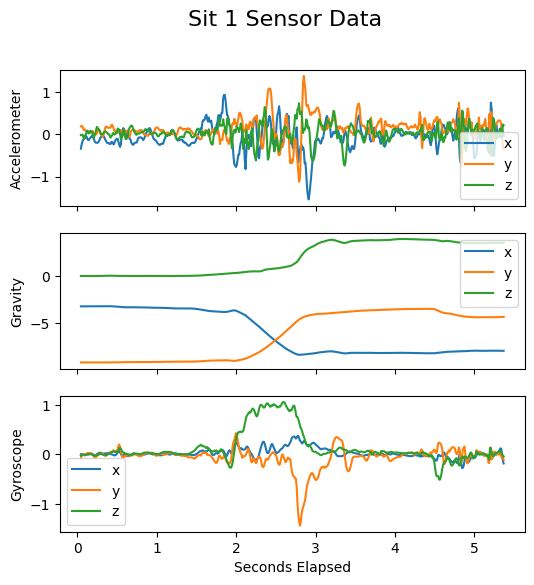

In [29]:
# ----------------------------------------------------------
# Visualize raw signals for Sit 1, Student 1
# ----------------------------------------------------------

# Extract accelerometer, gravity, and gyroscope dataframes
sit1_acc = data["Sit"]["1"]["Student1"]["accelerometer"]
sit1_grav = data["Sit"]["1"]["Student1"]["gravity"]
sit1_gyr = data["Sit"]["1"]["Student1"]["gyroscope"]

# Plot the 3 sensors together for Sit_1_Student1
plot_sensors(
    {
        "accelerometer": sit1_acc,
        "gravity": sit1_grav,
        "gyroscope": sit1_gyr
    },
    activity_name="Sit 1")

## 2) Preprocessing

### 2.1) Data Preprocessing

In this project, the preprocessing includes several key steps:  
- **Time Synchronization** → align all sensor signals to a common time base  
- **Trimming** → remove non-activity or idle periods from the recordings  
- **Windowing** → segment continuous signals into fixed-length windows for analysis and feature extraction  



#### 2.1.1 Time Synchronization

Although all sensor data was recorded at **100 Hz**, the actual timestamps may vary slightly between sensors and participants, meaning their signals are not perfectly aligned.  

A **time synchronization technique** was applied to align all signals to a common timeline, ensuring values from different sensors represent the same moment. With synchronized timestamps, the three sensors data are merged into a single dataset per trial.  



This is done with the code below.  
In summary, we:  
1. Clean each sensor dataset (numeric conversion, sorting, removing duplicates).  
2. Align all three sensors on a uniform 100 Hz timeline.  
3. Interpolate missing values.  
4. Discard values not on the timeline.  
5. Merge them into one synchronized dataset per trial and save.

In [ ]:
# ----------------------------------------------------------
# Function to synchronize the loaded data, and save
# ----------------------------------------------------------

def build_synchronized_dataset(
    loaded_data,
    out_dir = "Synchronized Data",
    fs = 100.0,
    float_fmt = "%.2f"
):
    """
    Synchronize the loaded data to a common timeline at `fs` Hz,
    save CSVs to disk, and return a nested dict:

        synced[activity][trial][student] = DataFrame
            columns: seconds_elapsed, acc_x/y/z, grav_x/y/z, gyro_x/y/z
    """

    REQUIRED_SENSORS = ("accelerometer", "gravity", "gyroscope")

    # ---------------------------
    # Helpers
    # ---------------------------

    def clean(df: pd.DataFrame) -> pd.DataFrame:
        """ Ensure numeric, sort by time, drop invalid/duplicate rows."""
        # Drop the time column
        df = df.drop(columns="time")
        # Ensure numeric
        df["seconds_elapsed"] = pd.to_numeric(df["seconds_elapsed"], errors="coerce")
        for c in df.columns:
            if c != "seconds_elapsed":
                df[c] = pd.to_numeric(df[c], errors="coerce")
        # Drop na and duplicates
        df = df.dropna(subset=["seconds_elapsed"]).sort_values("seconds_elapsed")
        df = df.drop_duplicates(subset=["seconds_elapsed"])
        return df
    
    def add_prefix(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
        """Prefix feature columns (e.g., x,y,z) with sensor tag (acc_, grav_, gyro_)."""
        return df.rename(columns={c: f"{prefix}_{c.lower()}" for c in df.columns if c != "seconds_elapsed"})


    def process_one_trial(sensor_dict: dict) -> pd.DataFrame:
        """Align accelerometer, gravity, and gyroscope signals to a uniform timeline."""
        # Check required sensors are present
        for r in REQUIRED_SENSORS:
            if r not in sensor_dict:
                raise FileNotFoundError(f"Missing sensor '{r}'")

        # Clean and rename columns for clarity
        acc  = add_prefix(clean(sensor_dict["accelerometer"].copy()), "acc")
        grav = add_prefix(clean(sensor_dict["gravity"].copy()), "grav")
        gyro = add_prefix(clean(sensor_dict["gyroscope"].copy()), "gyro")

        # Merge all sensors on time
        merged = (
            acc.merge(grav, on="seconds_elapsed", how="outer")
               .merge(gyro, on="seconds_elapsed", how="outer")
               .sort_values("seconds_elapsed")
               .reset_index(drop=True)
        )

        # Identify common overlapping time window
        start = max(acc["seconds_elapsed"].min(), grav["seconds_elapsed"].min(), gyro["seconds_elapsed"].min())
        end   = min(acc["seconds_elapsed"].max(), grav["seconds_elapsed"].max(), gyro["seconds_elapsed"].max())
        if not (end > start): 
            return pd.DataFrame()

        # Generate exact timeline at fs Hz
        start_tick, end_tick = int(np.ceil(start * fs)), int(np.floor(end * fs))
        timeline = np.arange(start_tick, end_tick + 1) / fs

        # Reindex and interpolate onto uniform timeline
        union_index = np.unique(np.concatenate([merged["seconds_elapsed"].values, timeline]))
        union_df = merged.set_index("seconds_elapsed").reindex(union_index).sort_index()
        num_cols = union_df.select_dtypes(include=[np.number]).columns
        union_df[num_cols] = union_df[num_cols].interpolate(method="linear", limit_direction="both")

        # Keep only target timeline values
        aligned = union_df.reset_index().rename(columns={"index": "seconds_elapsed"})
        aligned = aligned[aligned["seconds_elapsed"].isin(timeline)].reset_index(drop=True)

        # Round timestamps to exact multiples of fs
        aligned["seconds_elapsed"] = np.round(aligned["seconds_elapsed"] * fs).astype(int) / fs
        return aligned

    os.makedirs(out_dir, exist_ok=True)
    synced = {}

    # Iterate over activities, trials, and students
    for activity, trials in loaded_data.items():
        for trial, students in trials.items():
            for student, sensor_dict in students.items():
                folder_name = f"{activity}_{trial}_{student}"
                out_trial_dir = os.path.join(out_dir, folder_name)
                os.makedirs(out_trial_dir, exist_ok=True)

                # Build synchronized dataset for this trial
                try:
                    aligned = process_one_trial(sensor_dict)
                    if aligned.empty: 
                        continue
                except Exception:
                    continue

                # Save synchronized CSV
                aligned.to_csv(os.path.join(out_trial_dir, "sensor_data.csv"), index=False, float_format=float_fmt)

                # Store in nested dict
                synced.setdefault(activity, {}).setdefault(trial, {})[student] = aligned

    return synced

The folder structure mirrors the raw dataset:  
- **Folder name**: `{Activity}_{trial}_{student}`  
- **File**: `sensor_data.csv` → contains aligned and merged accelerometer, gravity, and gyroscope data.  

The synchronized data is saved **separately from the raw data** to ensure that the original recordings remain untouched.  
This separation prevents accidental overwriting, keeps the preprocessing pipeline reproducible, and makes it clear which files are raw and which are preprocessed.  

In [55]:
# Apply synchronization
synced = build_synchronized_dataset(
    loaded_data=data,
    out_dir="Synchronized Data",
    fs=100.0,
    float_fmt="%.4f"
)


Apart from saving the synchronized files to disk, the function also returns a nested dictionary synced with the structure:
**`synced[activity][trial][student]`**

Its structure is the same as the raw data dictionary, but now each entry contains a single merged DataFrame with the synchronized accelerometer, gravity, and gyroscope signals.

For example, the synchronized data for Student1 performing Sit activity, trial 1 can be accessed by:

In [57]:
synced["Sit"]["1"]["Student1"]

,seconds_elapsed,acc_z,acc_y,acc_x,grav_z,grav_y,grav_x,gyro_z,gyro_y,gyro_x
0,0.05,-0.021304,0.193194,-0.286599,0.037914,-9.258764,-3.231755,-0.020207,-0.057970,-0.000377
1,0.06,-0.015326,0.189547,-0.200339,0.038969,-9.259231,-3.230402,-0.009920,-0.017987,-0.002837
2,0.07,-0.030008,0.155911,-0.145342,0.038763,-9.259413,-3.229883,-0.003485,0.002401,-0.007196
3,0.08,-0.079296,0.115654,-0.102586,0.037772,-9.259483,-3.229693,-0.001808,-0.001130,-0.013970
4,0.09,-0.100334,0.104005,-0.060578,0.036439,-9.259581,-3.229429,-0.004059,-0.009976,-0.018337
...,...,...,...,...,...,...,...,...,...,...
527,5.32,0.123579,0.315094,0.032262,3.586686,-4.372518,-8.011688,0.063295,0.005025,0.107669
528,5.33,0.020065,0.275452,0.101335,3.592112,-4.363776,-8.014022,0.047529,-0.019902,0.114815
529,5.34,-0.070344,0.126455,0.131698,3.599247,-4.358056,-8.013933,0.015532,-0.060127,0.048145
530,5.35,0.085555,-0.141253,0.079827,3.604284,-4.358200,-8.011592,-0.010594,-0.069782,-0.068237


#### 2.1.2 Trimming

To ensure good model performance, the data must accurately reflect the activity being performed. Raw recordings often include setup, idle, or recovery periods. Trimming removes these irrelevant segments so that the features captured describe only the intended activity.

##### Trimming Approach

- **Sit / Stand (transitions):**  
  -  Because these are short, transient movements, we kept a fixed segment around the transition itself. 
  - This avoids including long idle periods before or after the action. 
  - If the recording was too short to extract the full segment, it was discarded.  

- **Walking / Running / Stairs (sustained):**  
  - These are continuous activities, so only a small portion was removed from the beginning and end of each trial.  
  - The remaining middle part of the recording, where the activity was steady, was kept.  
  - The trim values were defined per activity, allowing different amounts of start/end trimming.  

To support this trimming strategy, care was taken during data recording.  
- For **Sit and Stand**, students performed the transition around the same point in time after the recording starts (1s after), so the fixed window captures the action consistently across trials.  
- For **Walking, Running, and Stairs**, students began the activity promptly after recording starts and continue until the end, so that trimming the start-up and wind-down leaves a steady middle section.  

In [109]:
# ----------------------------------------------------------
# Trimming paramters
# ----------------------------------------------------------
sit_stand_start_offset_s = 1.5
window_size_s = 2.0
trims_start = {"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0} # Sit/Stand = 0 because they are handled by fixed-segment cropping
trims_end = {"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0}
sit_stand_set = ("Sit", "Stand")

In [ ]:
# ----------------------------------------------------------
# Function for trimming 
# ----------------------------------------------------------

# Time columns 
TIME_COL = "seconds_elapsed"

def _crop_segment(df, start_offset_s, duration_s, hz=100.0):
    """
    Fixed-length slice by sample count (index-based), e.g., for Sit/Stand.
    Returns empty if the requested window cannot be satisfied exactly.
    """
    if df is None or df.empty:
        return df

    # Convert offset and duration from seconds to samples
    n_off = int(round(float(start_offset_s) * hz))
    n_win = int(round(float(duration_s) * hz))
    if n_off < 0 or n_win <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    start_idx = n_off
    end_idx = start_idx + n_win

     # If outside valid range, return empty
    if start_idx >= len(df) or end_idx <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    # Clamp to available range
    start_idx = max(0, start_idx)
    end_idx = min(len(df), end_idx)

    # Require exact window length
    if end_idx - start_idx < n_win:
        return df.iloc[0:0].reset_index(drop=True)

    return df.iloc[start_idx:end_idx].reset_index(drop=True)


def _crop_trim(df, start_trim_s, end_trim_s):
    """
    Trim by time: drop 'start_trim_s' seconds from start and 'end_trim_s' from end.
    Return empty if trims remove all rows.
    """
    # Compute start and end bounds in seconds
    t_min, t_max = float(df[TIME_COL].min()), float(df[TIME_COL].max())
    start_bound = t_min + float(start_trim_s)
    end_bound   = t_max - float(end_trim_s)

    # If bounds overlap, return empty
    if start_bound >= end_bound:
        return df.iloc[0:0].reset_index(drop=True)
    
    # Filter rows within valid range
    out = df[(df[TIME_COL] >= start_bound) & (df[TIME_COL] <= end_bound)]
    return out.reset_index(drop=True)


def trim_mixed_combined(
    synced_data,
    sit_stand_start_offset_s=1.5,
    window_size_s=2.0,
    trims_start=None,
    trims_end=None,
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
):
    """
    Trim combined per-trial DataFrames.

    Input:
        synced_data[activity][trial][student] -> DataFrame (seconds_elapsed + features)
    Output:
        cropped[activity][trial][student] -> cropped DataFrame
    """
    if trims_start is None:
        trims_start = 2.0
    if trims_end is None:
        trims_end = 2.0

    def _resolve(activity, val):
        # Allow dict per-activity or global float
        return val.get(activity, val.get(activity.capitalize(), 0.0)) if isinstance(val, dict) else float(val)

    cropped = {}

    for activity, trials in synced_data.items():
        cropped[activity] = {}
        for trial, students in trials.items():
            cropped[activity][trial] = {}
            for student, df in students.items():
                if not isinstance(df, pd.DataFrame) or df.empty:
                    cropped[activity][trial][student] = df
                    continue

                if activity in sit_stand_set:
                    # Sit/Stand → crop fixed-length segment by sample count
                    out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, hz=hz)
                else:
                    # Other activities → trim by time, using per-activity values
                    s_trim = _resolve(activity, trims_start)
                    e_trim = _resolve(activity, trims_end)
                    out = _crop_trim(df, s_trim, e_trim)

                cropped[activity][trial][student] = out

    return cropped

In [94]:
# Apply trimming
trimmed = trim_mixed_combined(
    synced,
    sit_stand_start_offset_s,
    window_size_s,
    trims_start,
    trims_end,
    sit_stand_set,
    hz=100.0
)

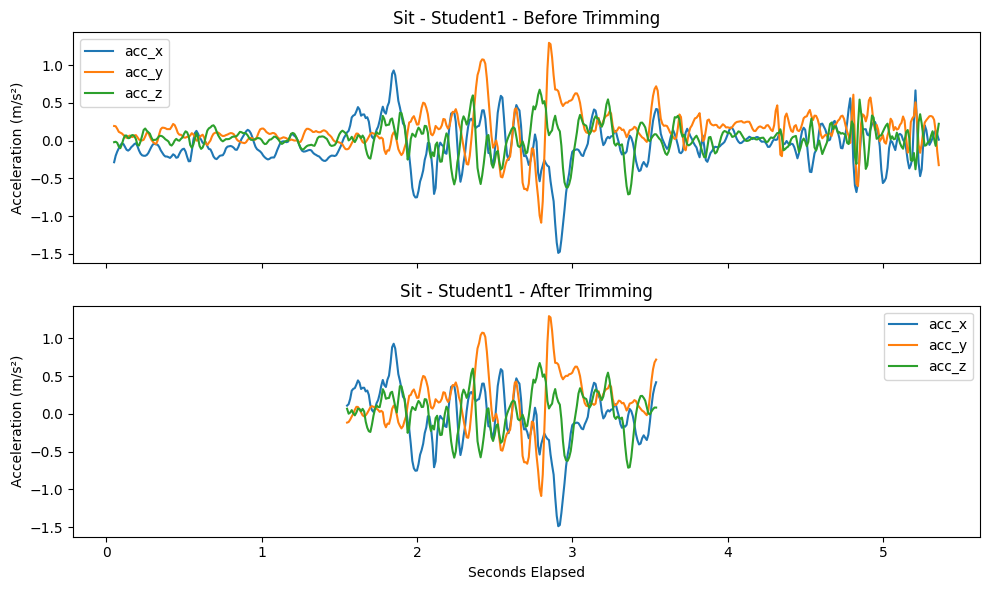

In [110]:
# ----------------------------------------------------------
# Visualize trimming results 
# ----------------------------------------------------------

# Get the DataFrames
df_synced  = synced["Sit"]["1"]["Student1"]
df_trimmed = trimmed["Sit"]["1"]["Student1"]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# --- Before trimming (synced)
axes[0].plot(df_synced["seconds_elapsed"], df_synced["acc_x"], label="acc_x")
axes[0].plot(df_synced["seconds_elapsed"], df_synced["acc_y"], label="acc_y")
axes[0].plot(df_synced["seconds_elapsed"], df_synced["acc_z"], label="acc_z")
axes[0].set_title("Sit - Student1 - Before Trimming")
axes[0].set_ylabel("Acceleration (m/s²)")
axes[0].legend()

# --- After trimming
axes[1].plot(df_trimmed["seconds_elapsed"], df_trimmed["acc_x"], label="acc_x")
axes[1].plot(df_trimmed["seconds_elapsed"], df_trimmed["acc_y"], label="acc_y")
axes[1].plot(df_trimmed["seconds_elapsed"], df_trimmed["acc_z"], label="acc_z")
axes[1].set_title("Sit - Student1 - After Trimming")
axes[1].set_xlabel("Seconds Elapsed")
axes[1].set_ylabel("Acceleration (m/s²)")
axes[1].legend()

plt.tight_layout()
plt.show()

#### (DISCUSSION TO BE REMOVED AND ADDED TO REPORT)

The fixed-segment trimming method for Sit and Stand is simple, consistent, and efficient in this training context since the data were collected in a controlled manner where participants performed transitions at roughly the same time. Because the cropping is strict, some idle frames may be included or parts of the transition missed, though most of the movement was still captured. However, this approach would not be efficient in uncontrolled settings, as participants may start the transition earlier or later, perform it at different speeds, or pause mid-action, making a fixed offset and duration unreliable. Future improvements for real-world implementation could involve signal-based detection to adaptively crop around the actual transition.

#### 2.1.3 Windowing

After trimming, a **windowing method** was applied to split the continuous sensor signals into **fixed-size samples**.  

In [115]:
# ----------------------------------------------------------
# Function for windowing
# ----------------------------------------------------------
def windowing(
    data_combined,
    window_size_s,
    step_s,
    keep_time_col
):
    """
    Split data into sliding windows.
    """
    HZ = 100.0  # sampling rate
    
    # For overlapping windows 
    if step_s is None:
        step_s = window_size_s   # default = non-overlapping windows

    # convert seconds to samples
    n_win = int(round(window_size_s * HZ))
    n_stp = int(round(step_s * HZ))
    if n_win <= 0 or n_stp <= 0:
        raise ValueError("window_size_s and step_s must be > 0.")

    def _make_windows(df):
        """Create sliding windows for one DataFrame."""
        if df is None or df.empty:
            return []
        N = len(df)
        last_start = N - n_win
        if last_start < 0:   # not enough rows for one full window
            return []
        out = []
        for s in range(0, last_start + 1, n_stp):
            e = s + n_win
            wdf = df.iloc[s:e].copy().reset_index(drop=True)
            if not keep_time_col and "seconds_elapsed" in wdf.columns:
                wdf = wdf.drop(columns=["seconds_elapsed"])
            out.append(wdf)
        return out

    # apply windowing to entire dataset
    windows = {}
    for activity, trials in data_combined.items():
        windows[activity] = {}
        for trial, students in trials.items():
            windows[activity][trial] = {}
            for student, df in students.items():
                windows[activity][trial][student] = _make_windows(df)

    return windows


In [118]:
# Apply windowing
win = windowing(
    trimmed,
    window_size_s,
    step_s=window_size_s, # non-overlapping windows
    keep_time_col=True
)

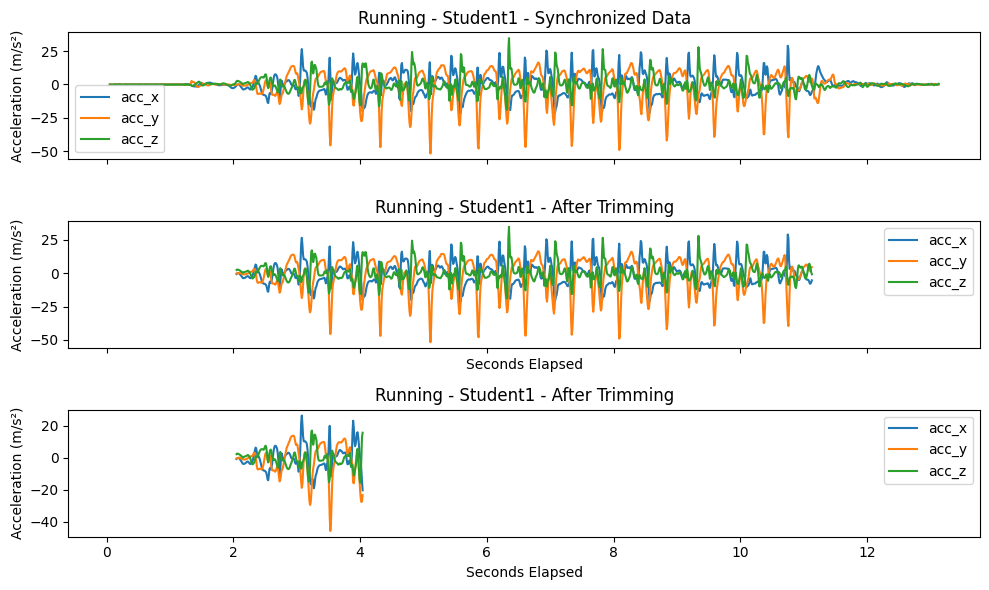

In [121]:
# ----------------------------------------------------------
# Visualize windowing results
# ----------------------------------------------------------

# Get the DataFrames
df_synced  = synced["Running"]["1"]["Student1"]
df_trimmed = trimmed["Running"]["1"]["Student1"]
df_windowed = win["Running"]["1"]["Student1"][0]

# Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# --- Synchronized data
axes[0].plot(df_synced["seconds_elapsed"], df_synced["acc_x"], label="acc_x")
axes[0].plot(df_synced["seconds_elapsed"], df_synced["acc_y"], label="acc_y")
axes[0].plot(df_synced["seconds_elapsed"], df_synced["acc_z"], label="acc_z")
axes[0].set_title("Running - Student1 - Synchronized Data")
axes[0].set_ylabel("Acceleration (m/s²)")
axes[0].legend()

# --- After trimming
axes[1].plot(df_trimmed["seconds_elapsed"], df_trimmed["acc_x"], label="acc_x")
axes[1].plot(df_trimmed["seconds_elapsed"], df_trimmed["acc_y"], label="acc_y")
axes[1].plot(df_trimmed["seconds_elapsed"], df_trimmed["acc_z"], label="acc_z")
axes[1].set_title("Running - Student1 - After Trimming")
axes[1].set_xlabel("Seconds Elapsed")
axes[1].set_ylabel("Acceleration (m/s²)")
axes[1].legend()

# --- After windowing
axes[2].plot(df_windowed["seconds_elapsed"], df_windowed["acc_x"], label="acc_x")
axes[2].plot(df_windowed["seconds_elapsed"], df_windowed["acc_y"], label="acc_y")
axes[2].plot(df_windowed["seconds_elapsed"], df_windowed["acc_z"], label="acc_z")
axes[2].set_title("Running - Student1 - After Trimming")
axes[2].set_xlabel("Seconds Elapsed")
axes[2].set_ylabel("Acceleration (m/s²)")
axes[2].legend()

plt.tight_layout()
plt.show()

#### 2.1.4 Saving Preprocessed Windows

In [128]:
# ----------------------------------------------------------
# Function to save windows
# ----------------------------------------------------------

def save_windows(windows, out_dir="windows"):
    """
    Save each window to its own CSV and create an index CSV.
    """
    os.makedirs(out_dir, exist_ok=True)
    index_rows = []

    for activity, trials in windows.items():
        for trial, students in trials.items():
            for student, win_list in students.items():
                # Skip if no windows for this (activity, trial, student)
                if not win_list:
                    continue

                for i, wdf in enumerate(win_list):
                    # e.g., windows_out/Walking/trial_1/Student2/win_0.csv
                    rel = os.path.join(activity, f"trial_{trial}", student, f"win_{i}.csv")
                    path = os.path.join(out_dir, rel)

                    # Ensure parent folders exist and save
                    os.makedirs(os.path.dirname(path), exist_ok=True)
                    wdf.to_csv(path, index=False)

                    # Record row for index
                    index_rows.append({
                        "activity": activity,
                        "trial": str(trial),
                        "student": student,
                        "window_idx": i,
                        "path": path
                    })

    # Build and persist index
    idx = pd.DataFrame(index_rows, columns=["activity", "trial", "student", "window_idx", "path"])
    idx.to_csv(os.path.join(out_dir, "index.csv"), index=False)
    return idx


In [131]:
# Save windows to disk
idx = save_windows(win, out_dir="windows")

# Count windows per activity
counts = idx.groupby("activity")["window_idx"].count().reset_index(name="num_windows")

print(counts)

  activity  num_windows
0  Running           57
1      Sit           50
2   Stairs           54
3    Stand           50
4  Walking           69


In [134]:
# Count windows per activity and per student
counts_as = (
    idx.groupby(["activity", "student"])["window_idx"]
       .count()
       .reset_index(name="num_windows")
)

print(counts_as)


  activity   student  num_windows
0  Running  Student1           26
1  Running  Student2           31
2      Sit  Student1           25
3      Sit  Student2           25
4   Stairs  Student1           24
5   Stairs  Student2           30
6    Stand  Student1           25
7    Stand  Student2           25
8  Walking  Student1           43
9  Walking  Student2           26


#### 2.1.5 Balanced Sampling of Windows

After windowing, the number of windows varies across activities and students.  
To train a fair model, we want each activity and each student to contribute the same number of windows.  
This prevents bias toward activities or participants with more data.


In [144]:
def sample_balanced_windows(idx, random_state=42):
    """
    Sample an equal number of windows per (activity, student) group.
    """
    # Count number of windows in each (activity, student) group
    counts_as = (
        idx.groupby(["activity", "student"])["window_idx"]
           .count()
           .rename("n")
           .reset_index()
    )

    # Find the minimum count across groups → safe sampling baseline
    N_PER_STUDENT = int(counts_as["n"].min())
    
    # Randomly sample exactly N_PER_STUDENT from each (activity, student) group
    sampled_idx = (
        idx.groupby(["activity", "student"], group_keys=False)
           .apply(lambda g: g.sample(n=N_PER_STUDENT, random_state=random_state))
           .reset_index(drop=True)
    )

    # Load the sampled windows into a nested dictionary
    selected = defaultdict(lambda: defaultdict(list))
    for _, row in sampled_idx.iterrows():
        df_win = pd.read_csv(row["path"])
        selected[row["activity"]][row["student"]].append(df_win)

    return selected, N_PER_STUDENT

In [145]:
selected, N = sample_balanced_windows(idx)

# Example access
print(f"Each group has {N} windows")

Each group has 24 windows


### 2.2) Feature Engineering and Feature Extraction

#### Summary of Features Calculated

(TBC)

In [153]:
FS = 100.0                         # sampling rate (Hz)
TIME_COLS = {"seconds_elapsed"}    # time column(s) to drop before feature calc


def _drop_time_cols(df):
    """Remove time columns to leave only numeric sensor channels."""
    drop = [c for c in df.columns if c in TIME_COLS]
    return df.drop(columns=drop) if drop else df


def _iqr(x):  return float(np.subtract(*np.percentile(x, [75, 25]))) if x.size else np.nan
def _mad(x):
    """Median Absolute Deviation."""
    if x.size == 0: return np.nan
    med = np.median(x)
    return float(np.median(np.abs(x - med)))
def _rms(x): return float(np.sqrt(np.mean(x.astype(float)**2))) if x.size else np.nan


def _dom_freq_and_mag(x, fs=FS):
    """Dominant frequency (Hz) and magnitude from rFFT (DC removed)."""
    n = x.size
    if n == 0: return np.nan, np.nan
    x = x.astype(float) - np.mean(x)
    X = np.fft.rfft(x, n=n)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    amp = np.abs(X) / n
    if amp.size: amp[0] = 0.0
    k = int(np.argmax(amp))
    return float(freqs[k]), float(amp[k])


def _spectral_energy_entropy(x, fs=FS):
    """Total spectral energy (per sample) and spectral entropy."""
    n = x.size
    if n == 0: return {"spec_energy": np.nan, "spec_entropy": np.nan}
    x = x.astype(float) - np.mean(x)
    X = np.fft.rfft(x, n=n)
    power = (np.abs(X)**2) / n
    power[0] = 0.0
    total_p = np.sum(power) + 1e-12
    p_norm = power / total_p
    return {
        "spec_energy": float(total_p / n),
        "spec_entropy": float(-np.sum(p_norm * np.log(p_norm + 1e-12))),
    }


def _sma(x, y=None, z=None):
    """Signal Magnitude Area across available axes."""
    parts = [a for a in (x, y, z) if a is not None]
    if not parts: return np.nan
    S = np.zeros_like(parts[0], dtype=float)
    for a in parts: S += np.abs(a.astype(float))
    return float(np.mean(S))


def _axis_features(x, prefix):
    """Comprehensive stats + spectral features for one vector."""
    x = np.asarray(x).astype(float)
    feats = {
        f"{prefix}_mean":   float(np.mean(x)) if x.size else np.nan,
        f"{prefix}_median": float(np.median(x)) if x.size else np.nan,
        f"{prefix}_std":    float(np.std(x, ddof=1)) if x.size > 1 else (0.0 if x.size == 1 else np.nan),
        f"{prefix}_var":    float(np.var(x, ddof=1)) if x.size > 1 else (0.0 if x.size == 1 else np.nan),
        f"{prefix}_min":    float(np.min(x)) if x.size else np.nan,
        f"{prefix}_max":    float(np.max(x)) if x.size else np.nan,
        f"{prefix}_range":  float(np.max(x) - np.min(x)) if x.size else np.nan,
        f"{prefix}_rms":    _rms(x),
        f"{prefix}_mad":    _mad(x),
        f"{prefix}_iqr":    _iqr(x),
        f"{prefix}_skew":   float(skew(x, bias=False)) if x.size > 2 else 0.0,
        f"{prefix}_kurt":   float(kurtosis(x, fisher=True, bias=False)) if x.size > 3 else 0.0,
    }
    f, a = _dom_freq_and_mag(x, fs=FS)
    feats[f"{prefix}_fft_dom_freq_hz"] = f
    feats[f"{prefix}_fft_dom_mag"] = a
    feats.update({f"{prefix}_{k}": v for k, v in _spectral_energy_entropy(x, fs=FS).items()})
    return feats


def _pair_corr(a, b, name):
    """Pearson correlation between two axes; 0 if any axis is constant."""
    a = np.asarray(a).astype(float); b = np.asarray(b).astype(float)
    if a.size < 2 or b.size < 2: return {f"{name}_corr": np.nan}
    sa, sb = np.std(a), np.std(b)
    if sa == 0 or sb == 0: return {f"{name}_corr": 0.0}
    return {f"{name}_corr": float(np.corrcoef(a, b)[0, 1])}


# Map prefixes in merged columns to canonical sensor names
SENSOR_ALIAS = {
    "acc": "accelerometer", "accelerometer": "accelerometer",
    "gyro": "gyroscope",    "gyroscope": "gyroscope",
    "grav": "gravity",      "gravity": "gravity",
}


def _split_merged_window(df):
    """
    Split merged window into per-sensor frames with columns [seconds_elapsed, x, y, z].
    Detects columns like 'acc_x', 'grav_y', 'gyro_z', etc.
    """
    time_cols = [c for c in df.columns if c in TIME_COLS]
    groups = {}
    pat = re.compile(r"^(acc|accelerometer|gyro|gyroscope|grav|gravity)_(x|y|z)$", re.IGNORECASE)

    for col in df.columns:
        if col in TIME_COLS: 
            continue
        m = pat.match(col)
        if not m:
            continue
        alias, axis = m.group(1).lower(), m.group(2).lower()
        sensor = SENSOR_ALIAS.get(alias)
        if not sensor:
            continue
        groups.setdefault(sensor, {"x": None, "y": None, "z": None})
        groups[sensor][axis] = col

    out = {}
    for sensor, axes in groups.items():
        cols = time_cols[:]
        for a in ("x", "y", "z"):
            if axes[a]:
                cols.append(axes[a])
        if cols:
            sub = df[cols].copy()
            rename_map = {axes[a]: a for a in ("x", "y", "z") if axes[a]}
            out[sensor] = sub.rename(columns=rename_map)
    return out


def features_from_window_df(df):
    """
    Auto-detect sensors in a merged window and compute features per sensor/axis.
    Falls back to 'merged_all' if no sensor-specific columns are found.
    """
    blocks = _split_merged_window(df)
    feats_all = {}

    if blocks:
        for sensor, subdf in blocks.items():
            d = _drop_time_cols(subdf)
            xs = d["x"].to_numpy() if "x" in d else None
            ys = d["y"].to_numpy() if "y" in d else None
            zs = d["z"].to_numpy() if "z" in d else None

            # per-axis features
            if xs is not None: feats_all |= _axis_features(xs, f"{sensor}_x")
            if ys is not None: feats_all |= _axis_features(ys, f"{sensor}_y")
            if zs is not None: feats_all |= _axis_features(zs, f"{sensor}_z")

            # vector magnitude (if at least two axes present)
            axes = [a for a in (xs, ys, zs) if a is not None]
            if len(axes) >= 2:
                mag = np.sqrt(np.sum([a.astype(float)**2 for a in axes], axis=0))
                feats_all |= _axis_features(mag, f"{sensor}_mag")

            # SMA + inter-axis correlations
            feats_all[f"{sensor}_sma"] = _sma(xs, ys, zs)
            if xs is not None and ys is not None: feats_all |= _pair_corr(xs, ys, f"{sensor}_xy")
            if xs is not None and zs is not None: feats_all |= _pair_corr(xs, zs, f"{sensor}_xz")
            if ys is not None and zs is not None: feats_all |= _pair_corr(ys, zs, f"{sensor}_yz")

        return feats_all

    # Fallback: compute features on all numeric columns together
    d = _drop_time_cols(df)
    num = d.select_dtypes(include=[np.number]).to_numpy()
    feats = {}
    if num.size:
        feats |= _axis_features(num.ravel(), "merged_all")
        feats["merged_sma"] = float(np.mean(np.abs(num.ravel().astype(float))))
    return feats


def extract_features_from_selected(selected):
    """
    Compute features directly from in-memory dict of sampled windows:
      selected[activity][student] -> list of DataFrames (windows)
    Returns a single DataFrame with metadata + features.
    """
    rows = []
    for activity, students in selected.items():
        for student, win_list in students.items():
            for i, df in enumerate(win_list):
                feats = features_from_window_df(df)
                row = {"activity": activity, "student": student, "window_idx": i}
                row.update(feats)
                rows.append(row)

    feat_df = pd.DataFrame(rows).sort_values(
        ["activity", "student", "window_idx"]
    ).reset_index(drop=True)

    # Replace infinities to keep downstream modeling tidy
    return feat_df.replace([np.inf, -np.inf], np.nan)

In [154]:
features = extract_features_from_selected(selected)

# Save for modeling
features.to_csv("features.csv", index=False)
print(features.shape)


(240, 207)


In [152]:
features

,activity,student,window_idx,accelerometer_x_mean,accelerometer_x_median,accelerometer_x_std,accelerometer_x_var,accelerometer_x_min,accelerometer_x_max,accelerometer_x_range,...,gyroscope_mag_skew,gyroscope_mag_kurt,gyroscope_mag_fft_dom_freq_hz,gyroscope_mag_fft_dom_mag,gyroscope_mag_spec_energy,gyroscope_mag_spec_entropy,gyroscope_sma,gyroscope_xy_corr,gyroscope_xz_corr,gyroscope_yz_corr
0,Running,Student1,0,1.021771,0.612588,5.342850,28.546050,-11.729695,22.628024,34.357720,...,1.268698,1.396896,0.5,0.680325,1.609890,2.859743,3.198407,-0.305953,0.306325,0.131533
1,Running,Student1,1,0.957057,1.137477,8.722620,76.084094,-16.669059,30.604844,47.273903,...,2.011424,5.814940,2.5,0.547142,1.608573,3.225626,4.691755,-0.398581,0.263138,0.018502
2,Running,Student1,2,-0.550652,-0.731393,7.784755,60.602415,-20.189716,26.526226,46.715942,...,1.410899,3.171090,0.5,0.581170,1.599986,2.996621,4.359430,-0.319767,0.438577,0.050305
3,Running,Student1,3,0.117944,0.629954,6.282686,39.472141,-13.057284,28.131823,41.189107,...,0.942157,0.680545,3.0,0.727509,2.408376,2.787412,5.479641,-0.141102,0.347690,-0.220020
4,Running,Student1,4,0.033404,0.839038,8.004673,64.074797,-18.465017,25.763795,44.228811,...,1.260366,2.509854,2.5,0.677232,1.602471,3.070957,5.785492,-0.379515,0.269805,0.180408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Walking,Student2,19,-0.460906,-0.620440,2.135249,4.559290,-6.905837,5.200264,12.106100,...,0.295067,-0.661892,2.0,0.171443,0.262912,3.210776,2.464528,-0.024232,0.021300,0.486207
236,Walking,Student2,20,-0.695712,-0.713888,1.909029,3.644392,-7.894448,3.477062,11.371511,...,0.145962,-0.562700,1.5,0.268437,0.288931,2.706518,2.362227,0.050933,0.012292,0.434536
237,Walking,Student2,21,-0.289060,-0.131476,1.728019,2.986048,-6.209784,3.625015,9.834800,...,1.508882,3.738639,1.0,0.198017,0.207140,2.934470,2.053892,-0.369135,0.652284,-0.084916
238,Walking,Student2,22,-0.473917,-0.451365,2.210730,4.887329,-6.656893,4.005083,10.661976,...,0.392045,-0.012158,1.5,0.290474,0.254412,2.322587,2.161812,0.301439,0.373910,0.474226


#### 2.2.2) Feature Selection

Filtering

In [155]:
# ---- imports (make sure these are present) ----
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

# ---- correlation filter (as you had) ----
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95, method="pearson", prefer="variance"):
        self.threshold = float(threshold)
        self.method = method
        self.prefer = prefer

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CorrelationFilter expects a pandas DataFrame.")
        Xdf = X.select_dtypes(include=[float, int])

        # choose order to evaluate columns (variance high to low is common)
        if self.prefer == "variance":
            order = Xdf.var(ddof=1).sort_values(ascending=False).index.tolist()
        elif self.prefer == "missing":
            var = Xdf.var(ddof=1)
            order = sorted(Xdf.columns, key=lambda c: (Xdf[c].isna().sum(), -var.get(c, 0.0)))
        else:
            order = list(Xdf.columns)

        self.corr_ = Xdf.corr(method=self.method).abs()
        kept, dropped = [], []
        for col in order:
            if any(self.corr_.loc[col, k] > self.threshold for k in kept if col != k):
                dropped.append(col)
            else:
                kept.append(col)
        self.kept_columns_ = kept
        self.dropped_columns_ = dropped
        return self

    def transform(self, X):
        cols = [c for c in self.kept_columns_ if c in X.columns]
        return X[cols]

# ---- variance + correlation pipeline (no MI) ----
def feature_filter_variance_corr(
    data_or_path,
    output_csv=None,
    meta_cols=("activity", "trial", "student", "window_idx"),
    variance_threshold=0.0,
    corr_threshold=0.95,
    corr_method="pearson",
    corr_prefer="variance",
):
    """
    Apply VarianceThreshold -> CorrelationFilter.
    Returns filtered DataFrame (with meta cols) and dropped lists.
    If `output_csv` is given, saves the filtered DataFrame.
    """
    # Load
    if isinstance(data_or_path, pd.DataFrame):
        df = data_or_path.copy()
    else:
        df = pd.read_csv(data_or_path)

    # Split meta and numeric features
    meta = df[[c for c in meta_cols if c in df.columns]].copy()
    X = df.drop(columns=[c for c in meta_cols if c in df.columns], errors="ignore")\
          .select_dtypes(include=[float, int])

    # Step 1: VarianceThreshold
    var_sel = VarianceThreshold(threshold=variance_threshold)
    var_sel.fit(X)
    mask = var_sel.get_support()
    kept_after_var = X.columns[mask].tolist()
    dropped_by_var = X.columns[~mask].tolist()
    X_var = pd.DataFrame(var_sel.transform(X), columns=kept_after_var, index=X.index)

    # Step 2: Correlation filter
    corr_filter = CorrelationFilter(
        threshold=corr_threshold,
        method=corr_method,
        prefer=corr_prefer
    )
    corr_filter.fit(X_var)
    kept_after_corr = corr_filter.kept_columns_
    dropped_by_corr = corr_filter.dropped_columns_
    X_corr = corr_filter.transform(X_var)

    # Recombine with meta
    df_out = pd.concat([meta.reset_index(drop=True), X_corr.reset_index(drop=True)], axis=1)

    # Save if requested
    if output_csv:
        df_out.to_csv(output_csv, index=False)

    return df_out, dropped_by_var, dropped_by_corr


In [159]:
var_threshold=0.01
corr_threshold=0.9
mi_k = 50

filtered, dropped_var, dropped_corr = feature_filter_variance_corr(
    features,                      # your features DataFrame
    output_csv="features_vc.csv",  # or None to skip saving
    variance_threshold=var_threshold,
    corr_threshold=corr_threshold,
    corr_method="pearson",
    corr_prefer="variance"
)

print("Dropped by variance:", len(dropped_var))
print("Dropped by correlation:", len(dropped_corr))
print(filtered.shape)


Dropped by variance: 12
Dropped by correlation: 92
(240, 103)


Wrapper Method

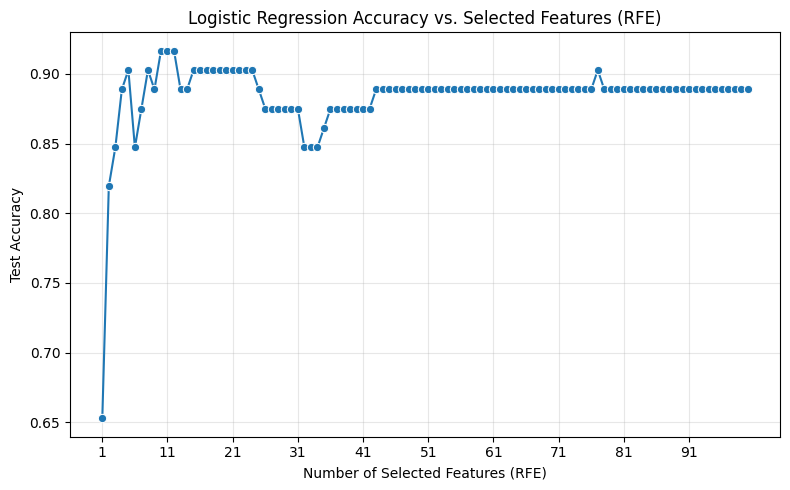

Best k = 10 with accuracy = 0.9167


In [163]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# -----------------------------
# Config
# -----------------------------
META_COLS = ("activity", "trial", "student", "window_idx")
RANDOM_STATE = 42
MAX_K = None  # set e.g. 100 to cap runtime when you have many features

# -----------------------------
# 0) Prepare X, y from your features DataFrame
#    (assumes `filtered` exists from your variance+correlation step)
# -----------------------------
df = filtered.copy()

y = df["activity"]
X = (
    df.drop(columns=[c for c in META_COLS if c in df.columns], errors="ignore")
      .select_dtypes(include=[np.number])
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0.0)
)

# Train/Test split (stratified by activity)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# -----------------------------
# 0.5) Scale features (important for LR)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# -----------------------------
# 1) RFE loop over #selected features
# -----------------------------
total_features = X_train_scaled.shape[1]
k_values = list(range(1, total_features + 1))
if MAX_K is not None:
    k_values = [k for k in k_values if k <= MAX_K]

rfe_accuracy_list = []

for k in k_values:
    # Base estimator
    base_model = LogisticRegression(
        max_iter=5000,
        random_state=RANDOM_STATE,
        solver="lbfgs"
    )

    # RFE → select top-k features
    selector = RFE(estimator=base_model, n_features_to_select=k, step=1)
    selector.fit(X_train_scaled, y_train)

    # Selected columns
    selected_cols = X_train_scaled.columns[selector.support_]

    # Retrain only on selected features
    base_model.fit(X_train_scaled[selected_cols], y_train)

    # Evaluate on test
    y_pred = base_model.predict(X_test_scaled[selected_cols])
    rfe_accuracy_list.append(accuracy_score(y_test, y_pred))

# -----------------------------
# 2) Plot Accuracy vs. Number of Selected Features
# -----------------------------
plt.figure(figsize=(8, 5))
sns.lineplot(x=k_values, y=rfe_accuracy_list, marker="o")
plt.xlabel("Number of Selected Features (RFE)")
plt.ylabel("Test Accuracy")
plt.title("Logistic Regression Accuracy vs. Selected Features (RFE)")
# Show fewer x-ticks if many features
if len(k_values) > 20:
    step = max(1, len(k_values)//10)
    plt.xticks(k_values[::step])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: print best k
best_idx = int(np.argmax(rfe_accuracy_list))
print(f"Best k = {k_values[best_idx]} with accuracy = {rfe_accuracy_list[best_idx]:.4f}")


In [ ]:
# -----------------------------
# 3) Find and Use Optimal Features
# -----------------------------

# Re-fit RFE with the optimal k
optimal_k = k_values[best_idx]
print(f"\n=== OPTIMAL FEATURE SELECTION ===")
print(f"Optimal number of features: {optimal_k}")
print(f"Best test accuracy: {rfe_accuracy_list[best_idx]:.4f}")

# Fit RFE one final time with optimal k
final_model = LogisticRegression(
    max_iter=5000,
    random_state=RANDOM_STATE,
    solver="lbfgs"
)

final_selector = RFE(estimator=final_model, n_features_to_select=optimal_k, step=1)
final_selector.fit(X_train_scaled, y_train)

# Get the optimal features
selected_mask = final_selector.support_
selected_feature_names = X_train_scaled.columns[selected_mask].tolist()
selected_feature_indices = np.where(selected_mask)[0]

print(f"\nSelected {optimal_k} optimal features:")
for i, feature in enumerate(selected_feature_names, 1):
    print(f"{i:2d}. {feature}")



=== OPTIMAL FEATURE SELECTION ===
Optimal number of features: 10
Best test accuracy: 0.9167

Selected 10 optimal features:
 1. gravity_z_min
 2. gravity_x_median
 3. accelerometer_z_iqr
 4. gravity_z_range
 5. gyroscope_x_max
 6. gyroscope_mag_spec_entropy
 7. gyroscope_mag_iqr
 8. accelerometer_y_mean
 9. accelerometer_z_spec_entropy
10. accelerometer_y_spec_entropy


In [175]:
features

,activity,student,window_idx,accelerometer_x_mean,accelerometer_x_median,accelerometer_x_std,accelerometer_x_var,accelerometer_x_min,accelerometer_x_max,accelerometer_x_range,...,gyroscope_mag_skew,gyroscope_mag_kurt,gyroscope_mag_fft_dom_freq_hz,gyroscope_mag_fft_dom_mag,gyroscope_mag_spec_energy,gyroscope_mag_spec_entropy,gyroscope_sma,gyroscope_xy_corr,gyroscope_xz_corr,gyroscope_yz_corr
0,Running,Student1,0,1.021771,0.612588,5.342850,28.546050,-11.729695,22.628024,34.357720,...,1.268698,1.396896,0.5,0.680325,1.609890,2.859743,3.198407,-0.305953,0.306325,0.131533
1,Running,Student1,1,0.957057,1.137477,8.722620,76.084094,-16.669059,30.604844,47.273903,...,2.011424,5.814940,2.5,0.547142,1.608573,3.225626,4.691755,-0.398581,0.263138,0.018502
2,Running,Student1,2,-0.550652,-0.731393,7.784755,60.602415,-20.189716,26.526226,46.715942,...,1.410899,3.171090,0.5,0.581170,1.599986,2.996621,4.359430,-0.319767,0.438577,0.050305
3,Running,Student1,3,0.117944,0.629954,6.282686,39.472141,-13.057284,28.131823,41.189107,...,0.942157,0.680545,3.0,0.727509,2.408376,2.787412,5.479641,-0.141102,0.347690,-0.220020
4,Running,Student1,4,0.033404,0.839038,8.004673,64.074797,-18.465017,25.763795,44.228811,...,1.260366,2.509854,2.5,0.677232,1.602471,3.070957,5.785492,-0.379515,0.269805,0.180408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Walking,Student2,19,-0.460906,-0.620440,2.135249,4.559290,-6.905837,5.200264,12.106100,...,0.295067,-0.661892,2.0,0.171443,0.262912,3.210776,2.464528,-0.024232,0.021300,0.486207
236,Walking,Student2,20,-0.695712,-0.713888,1.909029,3.644392,-7.894448,3.477062,11.371511,...,0.145962,-0.562700,1.5,0.268437,0.288931,2.706518,2.362227,0.050933,0.012292,0.434536
237,Walking,Student2,21,-0.289060,-0.131476,1.728019,2.986048,-6.209784,3.625015,9.834800,...,1.508882,3.738639,1.0,0.198017,0.207140,2.934470,2.053892,-0.369135,0.652284,-0.084916
238,Walking,Student2,22,-0.473917,-0.451365,2.210730,4.887329,-6.656893,4.005083,10.661976,...,0.392045,-0.012158,1.5,0.290474,0.254412,2.322587,2.161812,0.301439,0.373910,0.474226


In [179]:
# Meta columns to preserve
meta_cols = ["activity", "student", "window_idx"]

# Build new DataFrame with only selected features + metadata
df_optimal = pd.concat(
    [features[meta_cols], features[selected_feature_names]],
    axis=1
)

print(df_optimal.shape)

# Save to new CSV
df_optimal.to_csv("optimal_features.csv", index=False)

df_optimal


(240, 13)


,activity,student,window_idx,gravity_z_min,gravity_x_median,accelerometer_z_iqr,gravity_z_range,gyroscope_x_max,gyroscope_mag_spec_entropy,gyroscope_mag_iqr,accelerometer_y_mean,accelerometer_z_spec_entropy,accelerometer_y_spec_entropy
0,Running,Student1,0,-0.959653,0.153796,2.611635,3.425510,3.122638,2.859743,2.222112,-0.569931,3.161833,2.685771
1,Running,Student1,1,-1.995476,0.808198,4.745154,3.902691,3.960676,3.225626,1.865005,-1.670354,3.003638,2.065565
2,Running,Student1,2,-3.281623,2.190736,5.354027,6.479412,3.540876,2.996621,2.094501,-1.803859,3.147915,2.593997
3,Running,Student1,3,-3.358592,1.283790,11.897180,8.697499,5.726045,2.787412,2.968508,-1.536564,2.884513,2.539625
4,Running,Student1,4,-2.406601,0.819538,6.055684,4.723087,3.151059,3.070957,2.326358,-0.741976,3.373264,1.972839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Walking,Student2,19,-5.100734,-0.954625,5.577615,6.381634,2.460413,3.210776,1.120844,-0.170879,2.316137,2.639309
236,Walking,Student2,20,-4.874261,0.117776,5.411232,6.379435,2.094199,2.706518,0.974497,-0.424822,2.378187,2.631951
237,Walking,Student2,21,-4.351664,-2.049331,3.461256,6.475218,1.880396,2.934470,0.621134,-0.383282,2.009767,2.424715
238,Walking,Student2,22,-5.217509,1.446557,4.456621,6.475365,2.223702,2.322587,0.878129,-0.546254,2.271250,2.827365


## 3) Supervised Learning

## 4) Unsupervised Learning